# Penalaan Parameter PID Menggunakan Deep Learning pada Kit iTCLab dan Pemantauannya Menggunakan Internet of Things (IoT)

![Deep-PID-iTCLab-IoT](DL07.jpg)
Proses penalaan nilai Kc, τI dan τD pada
pengendali PID menggunakan Deep Learning pada Kit iTCLab dan Pemantauannya Menggunakan Internet of Things (IoT)

In [1]:
import itclab
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
from paho.mqtt import client as mqtt_client

In [2]:
# Machine Learning - Building Datasets and Model
# Impor `Sequential` dari` keras.models`
from keras.models import Sequential

# Impor `Dense` dari` keras.layers`
from keras.layers import Dense

# Inisialisasi konstruktor
model = Sequential()

# Tambahkan lapisan masukan 
model.add(Dense(2, activation='sigmoid', input_shape=(2,)))

# Tambahkan satu lapisan tersembunyi
model.add(Dense(3, activation='sigmoid'))

# Tambahkan lapisan keluaran
model.add(Dense(3, activation='sigmoid'))

# Data Latih.
X = np.array([
    [1, 1],
    [0.4, 1.2],
    [1.2, 0.1],
    [1, 0.1]
])

# Label untuk Data Latih.
y = np.array([
    [0.25, 4.31, 0.20],
    [0.2, 4.1, 0.1],
    [0.1, 4.0, 0],
    [0.1, 4.0, 0]
])

# Bentuk keluaran model
model.output_shape

# Ringkasan model
model.summary()

# Konfigurasi model
model.get_config()

# Buat daftar semua tensor bobot 
model.get_weights()

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 27 (108.00 B)

 Non-trainable params: 0 (0.00 B)

[array([[-0.54675174,  0.7649219 ],
        [ 0.3873315 ,  0.23795271]], dtype=float32),
 array([0., 0.], dtype=float32),
 array([[ 0.6438123 ,  0.2808634 ,  0.89739394],
        [ 0.43921685, -0.48424906, -0.78026974]], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([[-0.9429927 ,  0.9514642 , -0.12367892],
        [-0.52843404, -0.8754189 ,  0.50642395],
        [-0.7624755 , -0.70965266,  0.20354843]], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

In [3]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
model.fit(X, y,epochs=10, batch_size=1, verbose=1)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.0000e+00 - loss: 0.7947
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0000e+00 - loss: 0.7466 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - loss: 0.7428 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.6994 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0000e+00 - loss: 0.6765
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0000e+00 - loss: 0.6565
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.0000e+00 - loss: 0.6479
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0000e+00 - loss: 0.6120
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0000e+00 - loss: 0.6058 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - loss: 0.5835 


In [4]:
######################################################
# Use this script for evaluating model predictions   #
# and PID controller performance for the TCLab       #
# Adjust only PID and model sections                 #
######################################################

######################################################
# PID Controller                                     #
######################################################
# inputs -----------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs ----------------------------------
# op = output of the PID controller
# P = proportional contribution
# I = integral contribution
# D = derivative contribution
def pid(sp,pv,pv_last,ierr,dt):
    Kc   = 10.0 # K/%Heater
    tauI = 50.0 # sec
    tauD = 1.0  # sec
    # Parameters in terms of PID coefficients
    KP = Kc
    KI = Kc/tauI
    KD = Kc*tauD
    # ubias for controller (initial heater)
    op0 = 0 
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    # calculate the error
    error = sp-pv
    # calculate the integral error
    ierr = ierr + KI * error * dt
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    # return the controller output and PID terms
    return [op,P,I,D]

In [5]:
######################################################
# PID Controller using Deep Learning                 #
######################################################
# inputs -----------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs ----------------------------------
# op = output of the PID controller
# P = proportional contribution
# I = integral contribution
# D = derivative contribution

def pid_dl(sp,pv,pv_last,ierr,dt):

    # calculate the error
    error = sp-pv
    d_error = sp-pv_last
    delta_error = (error - d_error)
    
    outDL = model.predict(np.array([[error,delta_error]]))
    
    Kc = outDL[0,0]
    tauI = outDL[0,1]
    tauD = outDL[0,2]
    
    # Parameters in terms of PID coefficients
    KP = Kc
    KI = Kc/tauI
    KD = Kc*tauD
    # ubias for controller (initial heater)
    op0 = 0 
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0

    # calculate the integral error
    ierr = ierr + KI * error * dt
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    # return the controller output and PID terms
    return [op,P,I,D]

In [6]:
######################################################
# FOPDT model                                        #
######################################################
Kp = 0.5      # degC/%
tauP = 120.0  # seconds
thetaP = 10   # seconds (integer)
Tss = 23      # degC (ambient temperature)
Qss = 0       # % heater

######################################################
# Energy balance model                               #
######################################################
def heat(x,t,Q):
    # Parameters
    Ta = 23 + 273.15   # K
    U = 10.0           # W/m^2-K
    m = 4.0/1000.0     # kg
    Cp = 0.5 * 1000.0  # J/kg-K    
    A = 12.0 / 100.0**2 # Area in m^2
    alpha = 0.01       # W / % heater
    eps = 0.9          # Emissivity
    sigma = 5.67e-8    # Stefan-Boltzman

    # Temperature State 
    T = x[0]

    # Nonlinear Energy Balance
    dTdt = (1.0/(m*Cp))*(U*A*(Ta-T) \
            + eps * sigma * A * (Ta**4 - T**4) \
            + alpha*Q)
    return dTdt

In [7]:
# Connect to MQTT Broker for Monitoring
broker = 'broker.hivemq.com'
port = 1883
client_id = f'python-mqtt-{random.randint(0, 1000)}'

def connect_mqtt():
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker!")
        else:
            print("Failed to connect, return code %d\n", rc)

    client = mqtt_client.Client(client_id)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

client = connect_mqtt()
client.loop_start()

Connected to MQTT Broker!


Opening connection
iTCLab connected via Arduino on port COM5
LED On
Running Main Loop. Ctrl-C to end.
  Time     SP     PV     Q1   =  P   +  I  +   D
   0.0  25.00  26.01   0.00   0.00   0.00   0.00


<Figure size 1000x700 with 0 Axes>

C:\Users\Admin\AppData\Local\Temp\ipykernel_3696\1651458971.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tp[i] = Tnext[1]-273.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
   1.0  25.00  26.04   0.00  -0.21   0.00  -0.00


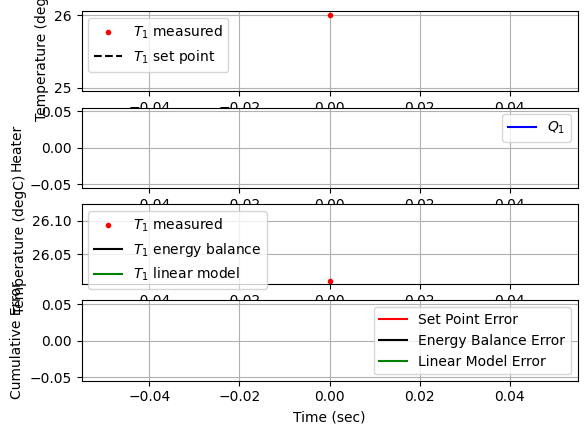

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
   3.9  25.00  26.10   0.00  -0.22   0.00  -0.00


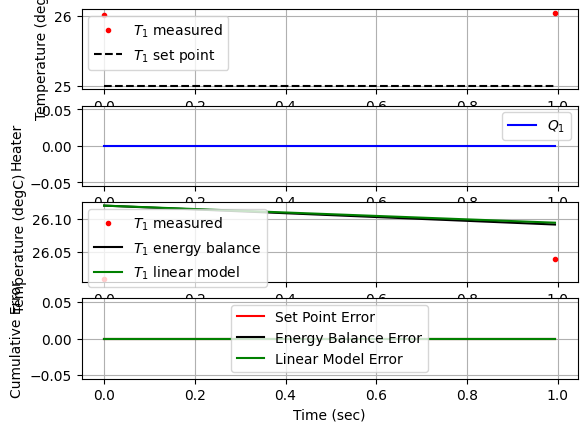

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
   7.7  25.00  26.04   0.00  -0.21   0.00   0.00


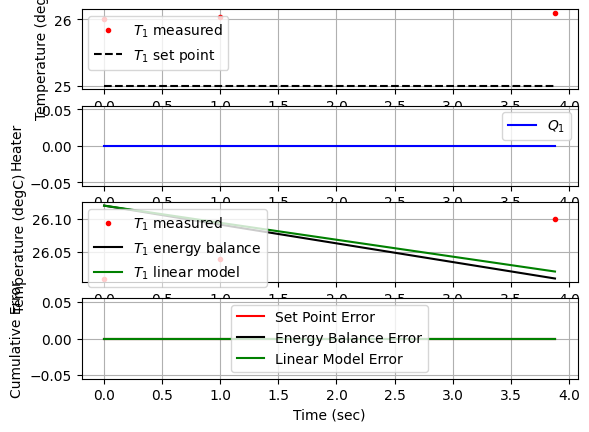

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
  13.4  25.00  26.00   0.00  -0.20   0.00   0.00


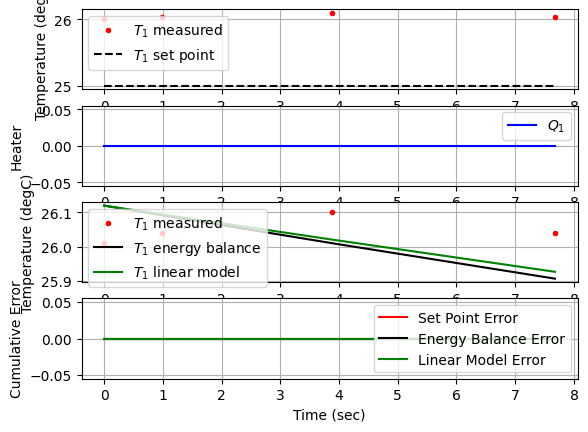

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
  18.8  25.00  26.11   0.00  -0.22   0.00  -0.00


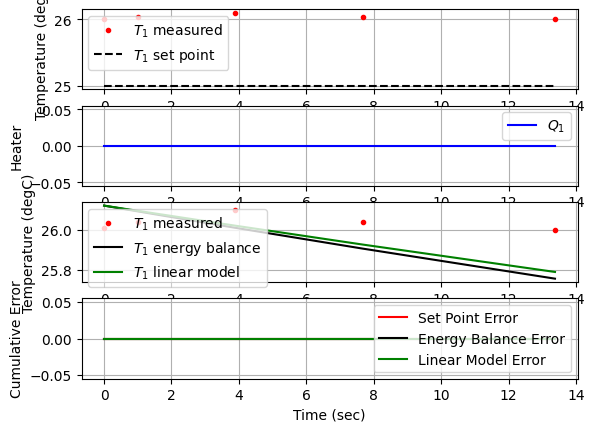

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
  22.3  25.00  26.02   0.00  -0.21   0.00   0.00


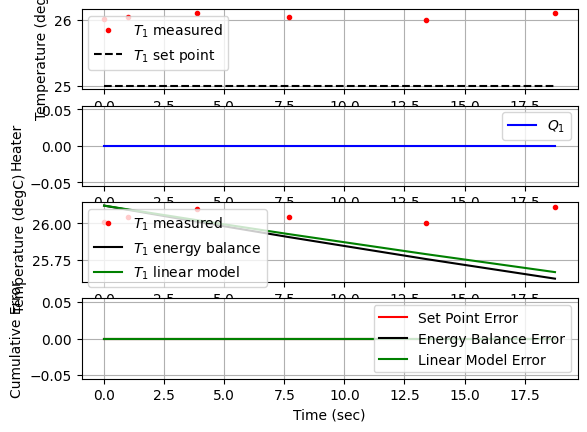

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
  27.6  25.00  26.15   0.00  -0.23   0.00  -0.00


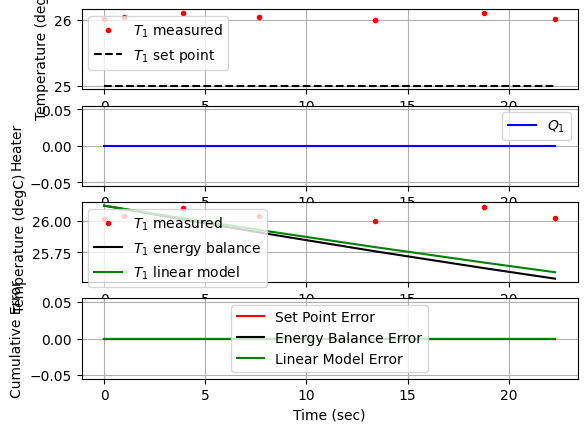

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
  31.2  25.00  26.02   0.00  -0.21   0.00   0.00


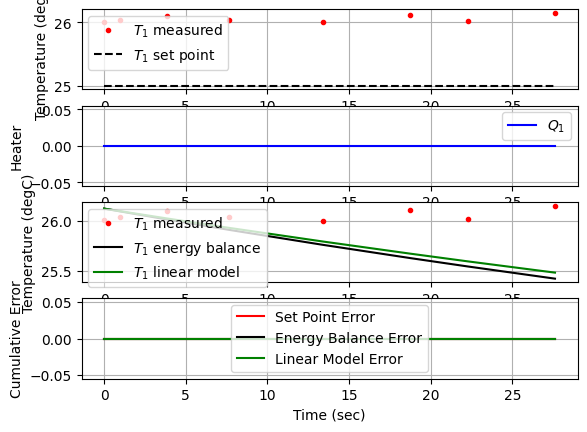

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
  35.0  25.00  26.10   0.00  -0.22   0.00  -0.00


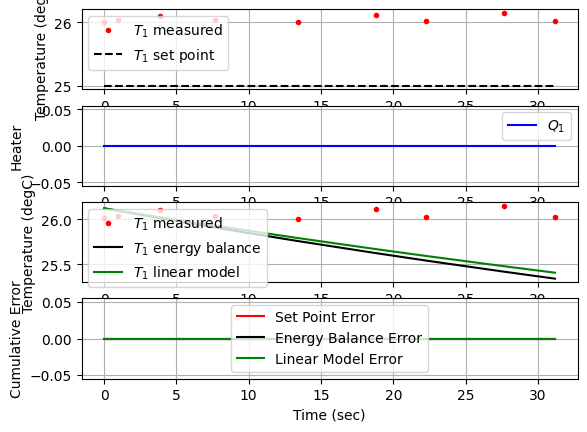

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
  39.0  25.00  26.03   0.00  -0.21   0.00   0.00


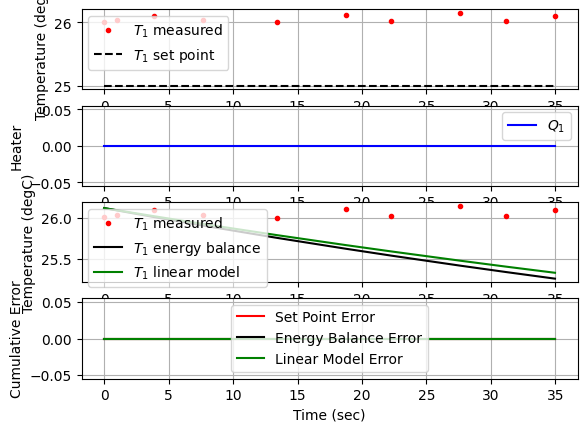

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
  41.6  25.00  26.09   0.00  -0.22   0.00  -0.00


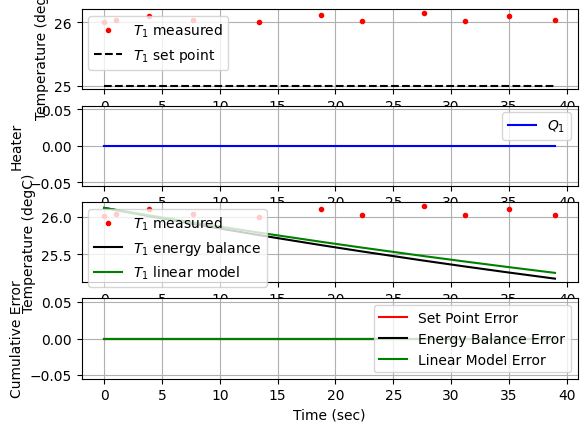

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
  44.8  25.00  26.11   0.00  -0.22   0.00  -0.00


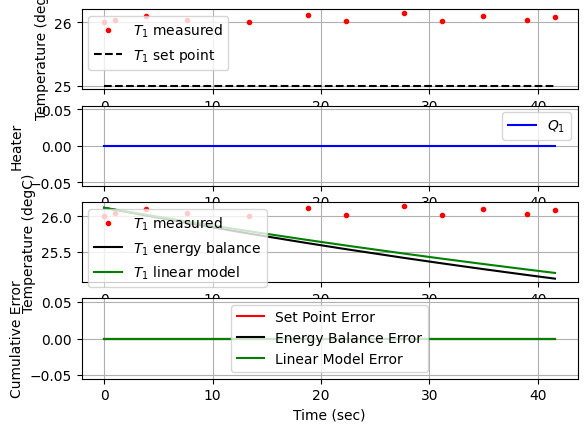

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
  47.4  25.00  26.05   0.00  -0.21   0.00   0.00


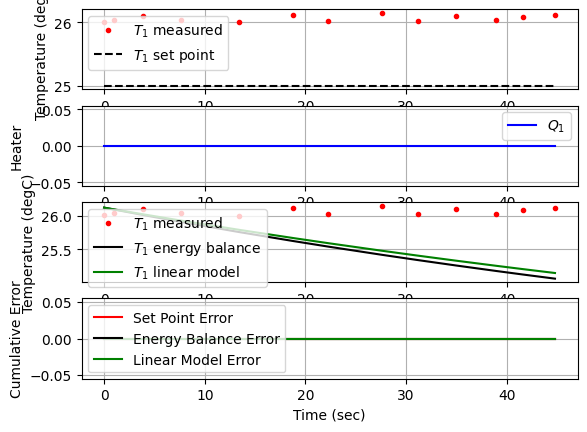

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
  50.8  25.00  26.06   0.00  -0.21   0.00  -0.00


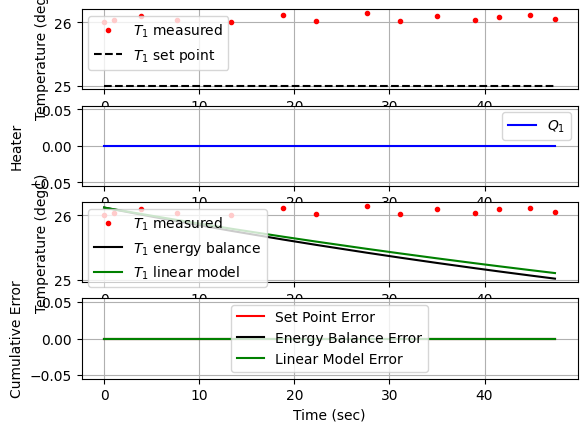

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
  53.5  25.00  26.11   0.00  -0.22   0.00  -0.00


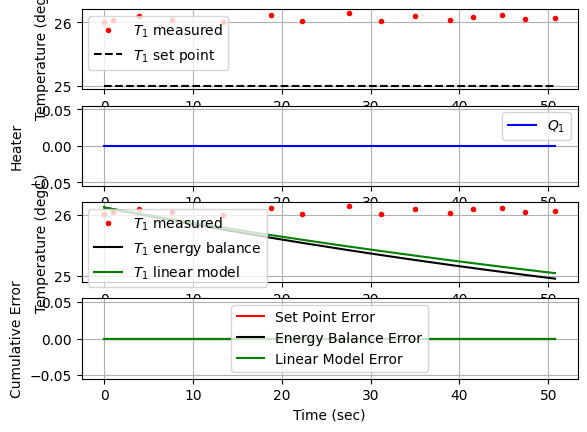

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
  56.1  25.00  26.15   0.00  -0.23   0.00  -0.00


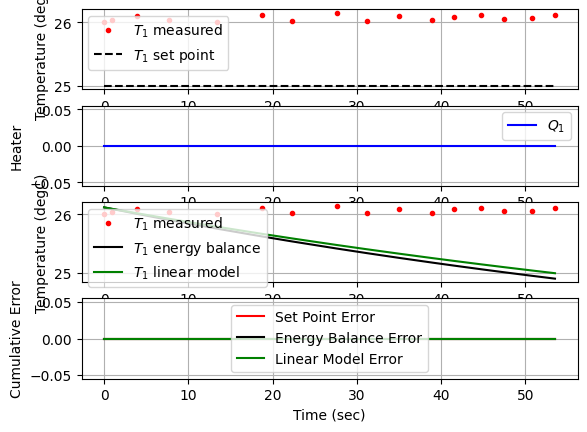

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
  59.1  25.00  26.04   0.00  -0.21   0.00   0.00


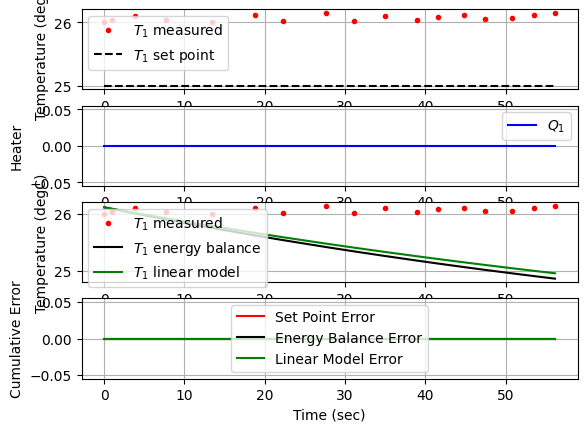

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
  61.5  25.00  26.10   0.00  -0.22   0.00  -0.00


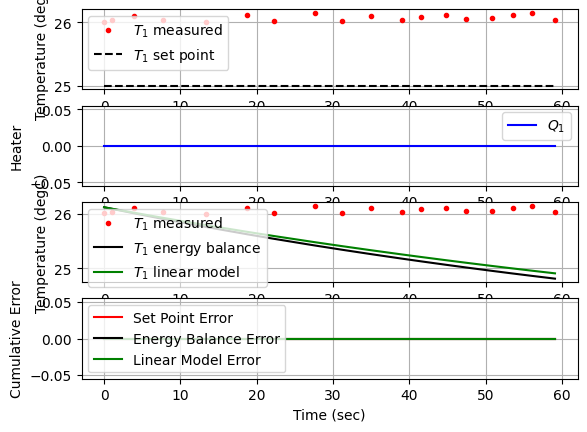

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
  64.2  25.00  26.14   0.00  -0.23   0.00  -0.00


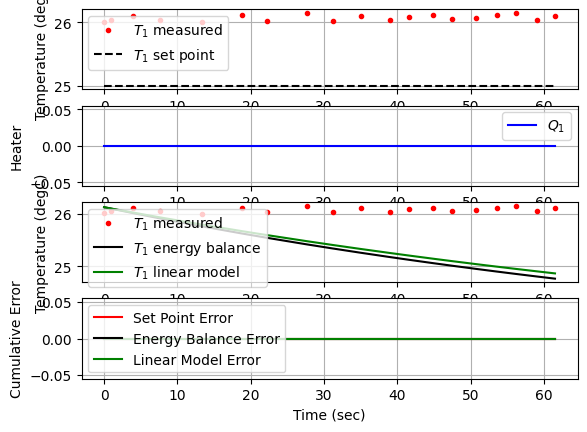

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
  67.0  25.00  26.08   0.00  -0.22   0.00   0.00


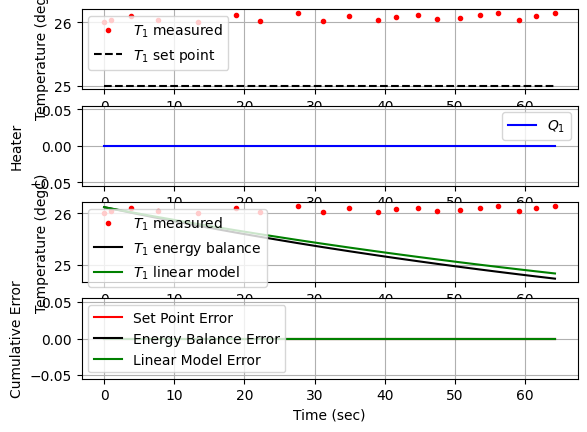

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
  69.9  25.00  26.06   0.00  -0.21   0.00   0.00


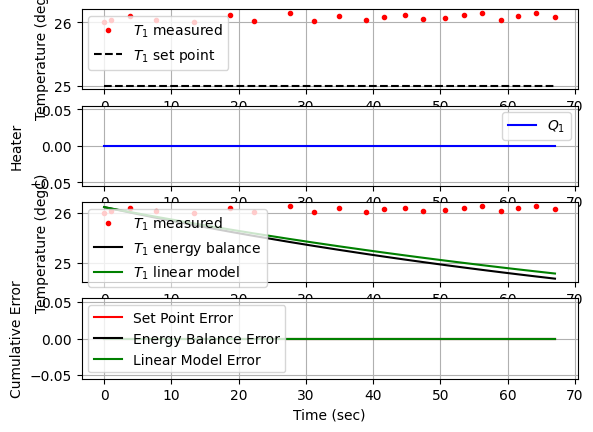

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
  73.3  25.00  26.03   0.00  -0.21   0.00   0.00


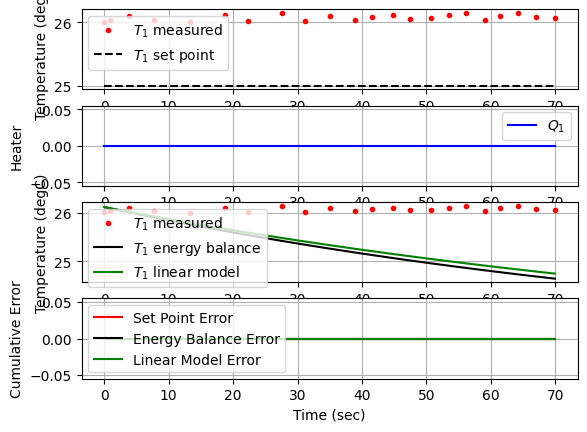

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
  76.4  25.00  26.08   0.00  -0.22   0.00  -0.00


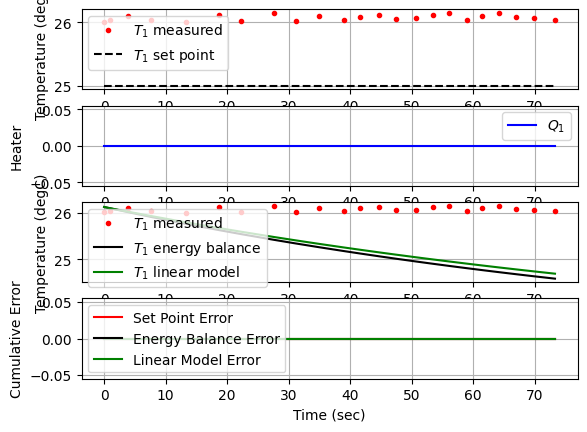

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
  79.1  25.00  26.05   0.00  -0.21   0.00   0.00


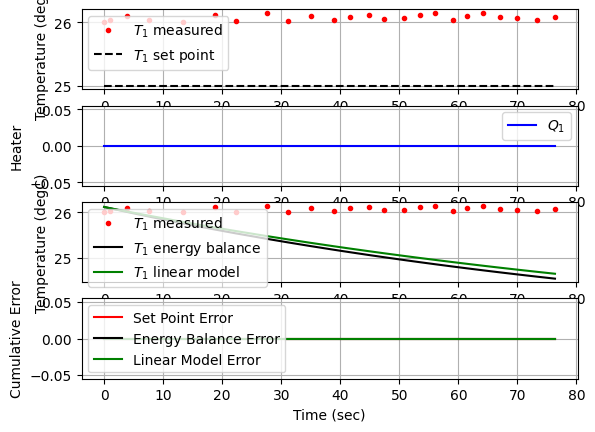

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
  81.8  25.00  26.10   0.00  -0.22   0.00  -0.00


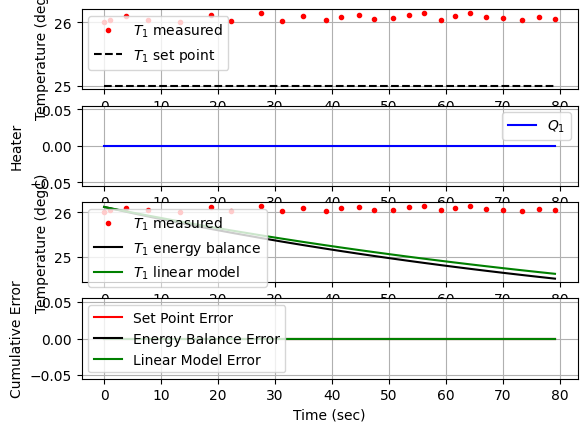

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
  84.7  25.00  26.07   0.00  -0.22   0.00   0.00


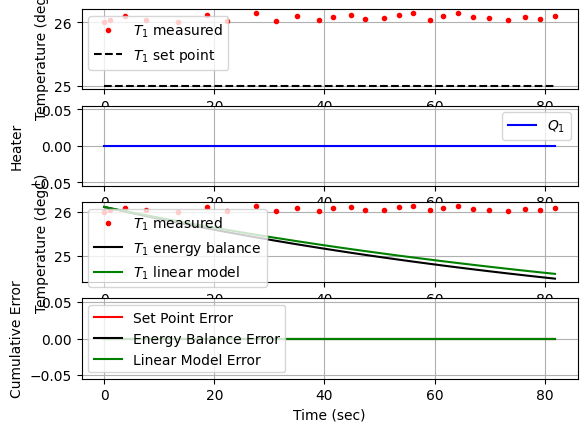

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
  87.6  25.00  26.10   0.00  -0.22   0.00  -0.00


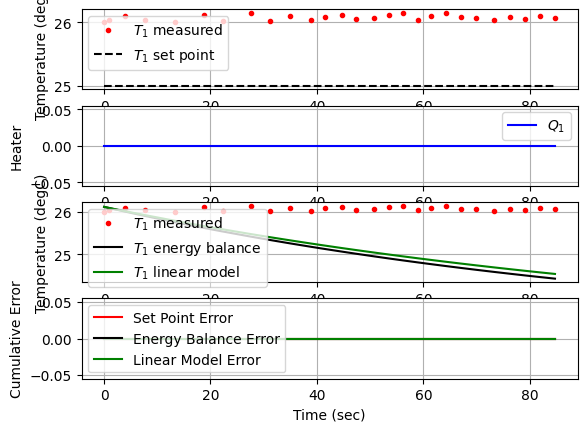

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
  90.3  25.00  26.09   0.00  -0.22   0.00   0.00


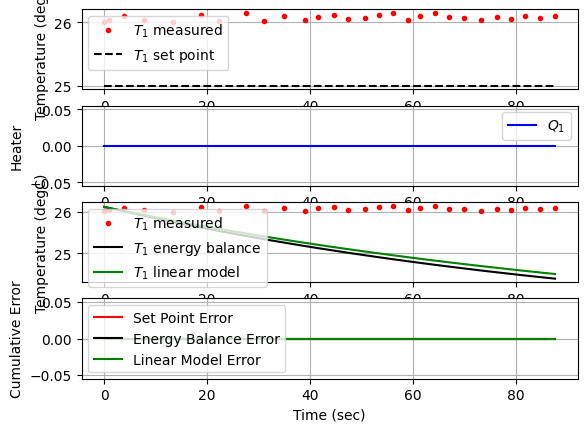

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
  93.5  25.00  26.20   0.00  -0.24   0.00  -0.00


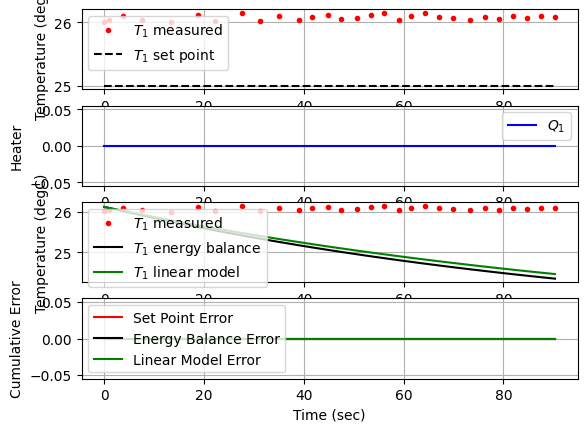

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
  96.2  25.00  26.07   0.00  -0.21   0.00   0.01


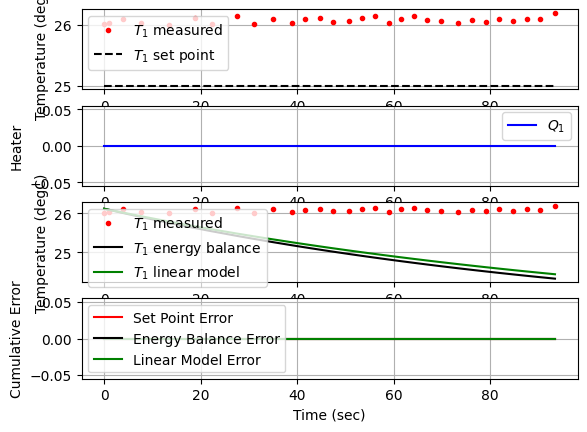

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
  99.3  25.00  26.14   0.00  -0.23   0.00  -0.00


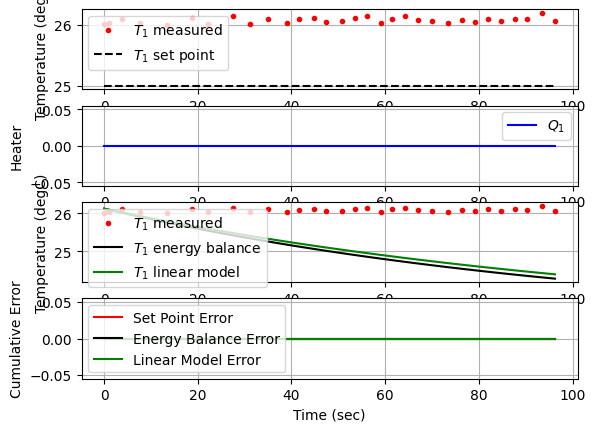

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
 103.2  25.00  26.00   0.00  -0.20   0.00   0.00


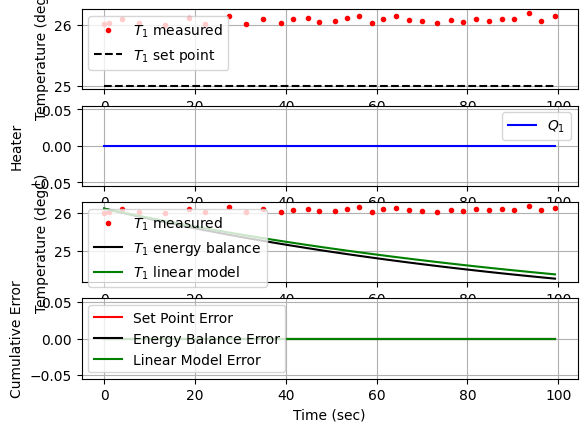

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
 108.7  25.00  26.12   0.00  -0.23   0.00  -0.00


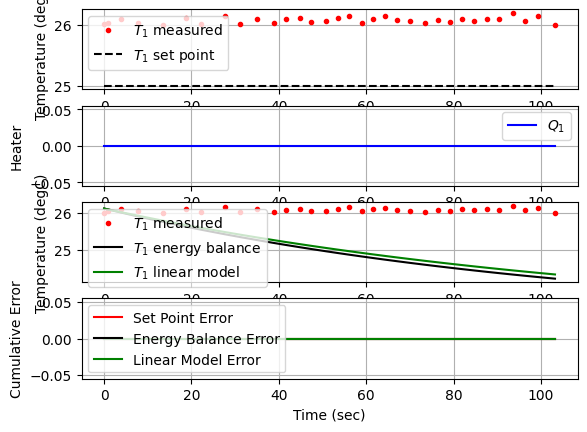

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
 111.7  25.00  26.10   0.00  -0.22   0.00   0.00


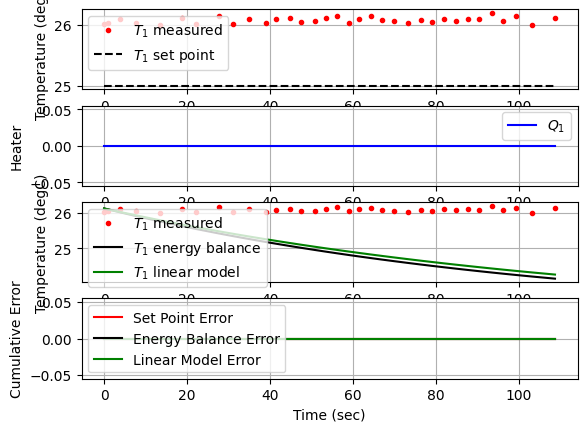

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
 114.2  25.00  26.06   0.00  -0.21   0.00   0.00


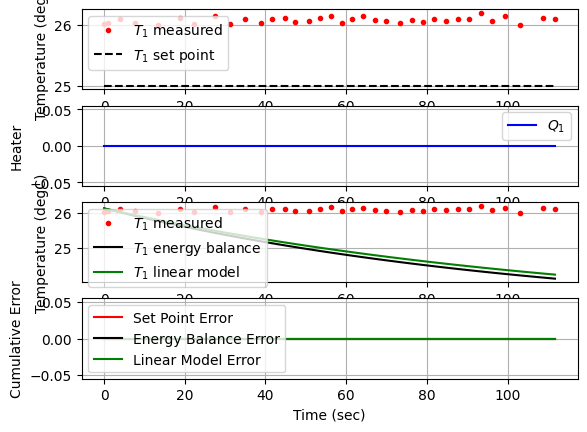

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
 117.3  25.00  26.09   0.00  -0.22   0.00  -0.00


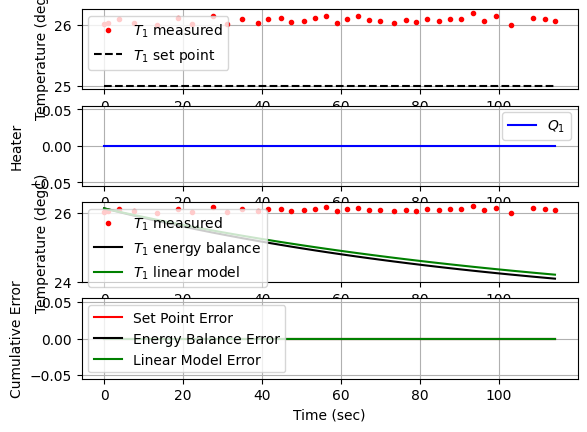

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
 120.2  25.00  26.17   0.00  -0.23   0.00  -0.00


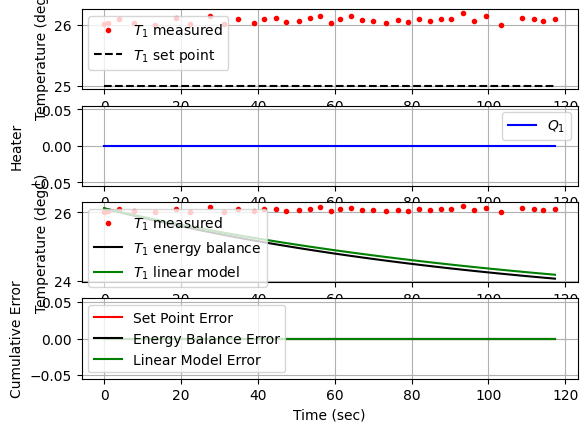

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
 122.9  25.00  26.05   0.00  -0.21   0.00   0.00


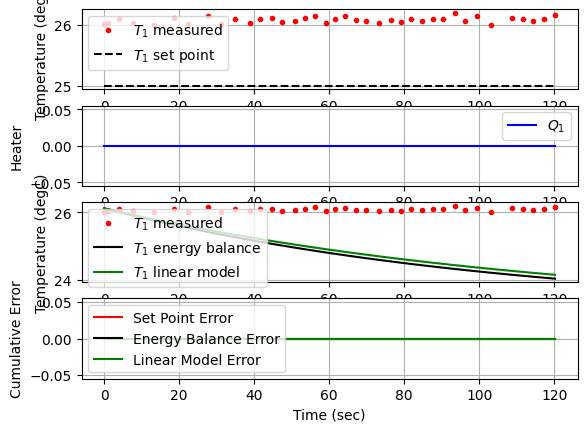

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
 125.9  25.00  26.11   0.00  -0.22   0.00  -0.00


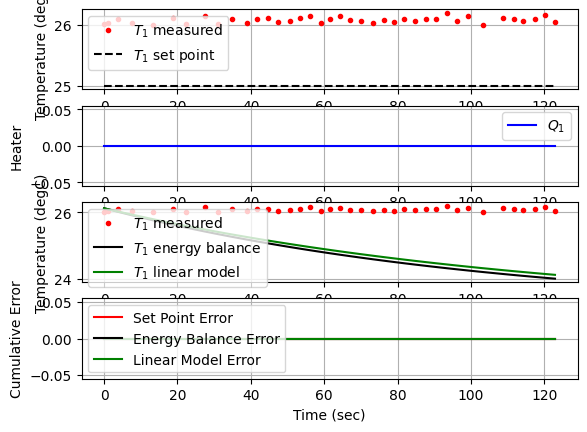

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
 128.6  25.00  26.11   0.00  -0.22   0.00  -0.00


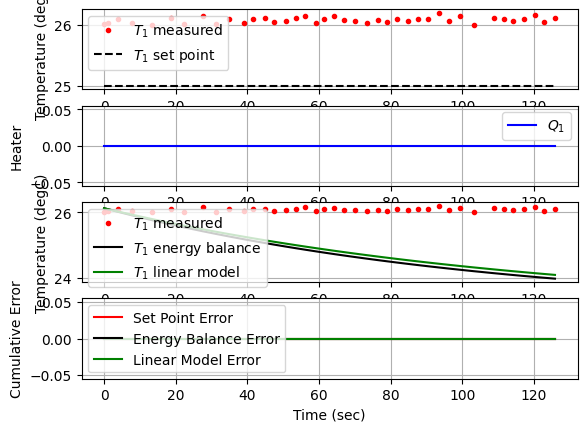

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
 131.4  25.00  26.05   0.00  -0.21   0.00   0.00


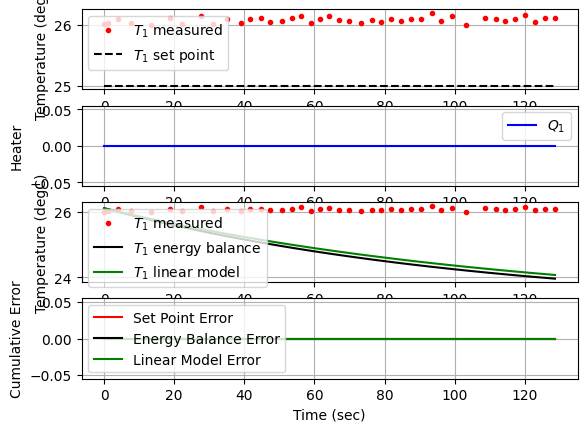

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
 135.4  25.00  26.06   0.00  -0.21   0.00  -0.00


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x0000026D95D67880>
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\transforms.py", line 195, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
KeyboardInterrupt: 


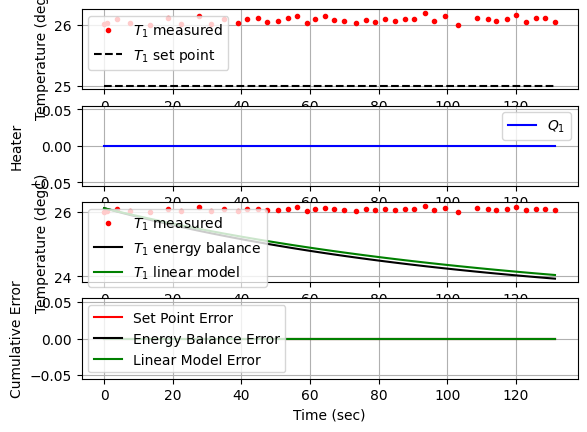

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
 138.9  25.00  26.01   0.00  -0.20   0.00   0.00


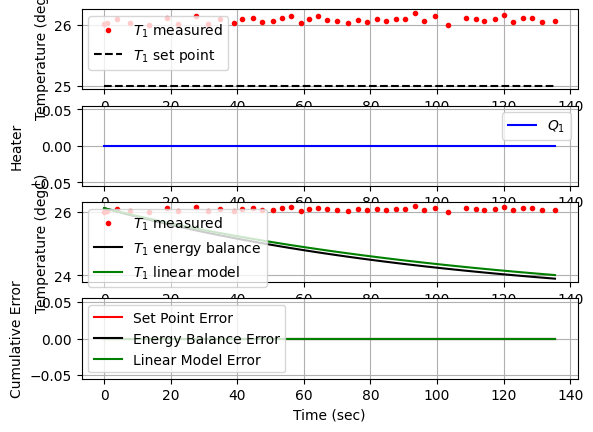

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
 142.5  25.00  26.09   0.00  -0.22   0.00  -0.00


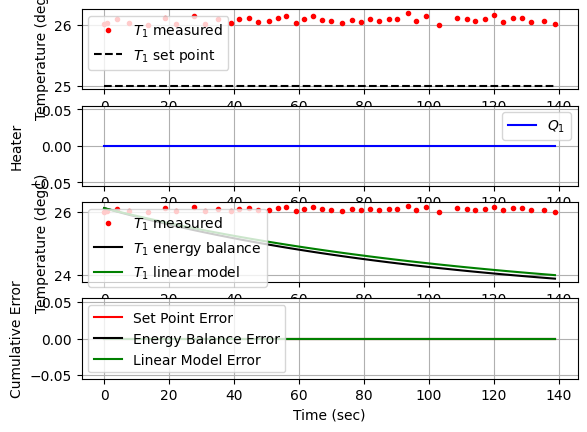

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
 145.7  25.00  26.11   0.00  -0.22   0.00  -0.00


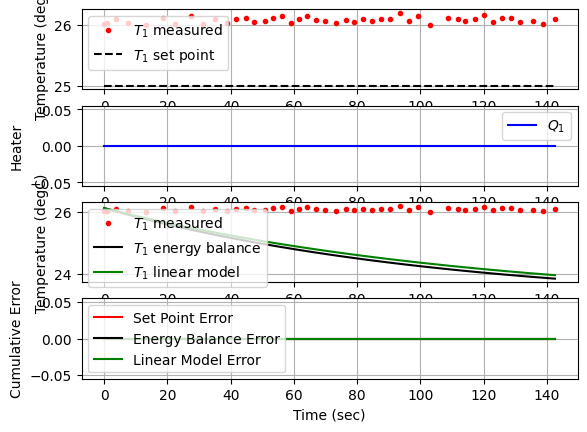

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
 148.7  25.00  26.08   0.00  -0.22   0.00   0.00


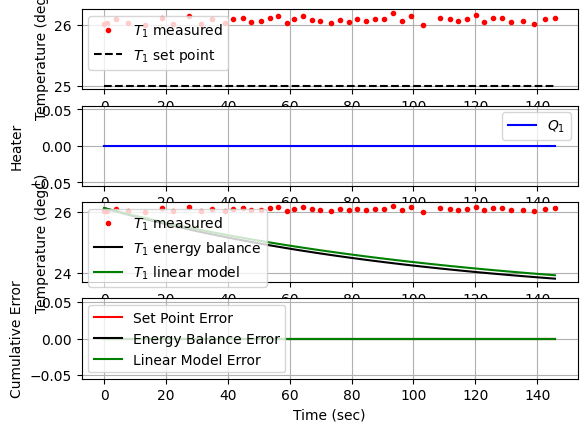

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
 151.3  25.00  25.98   0.00  -0.20   0.00   0.00


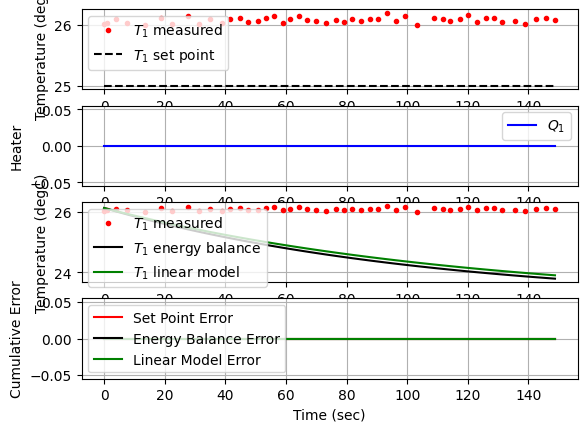

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
 153.7  25.00  26.05   0.00  -0.21   0.00  -0.00


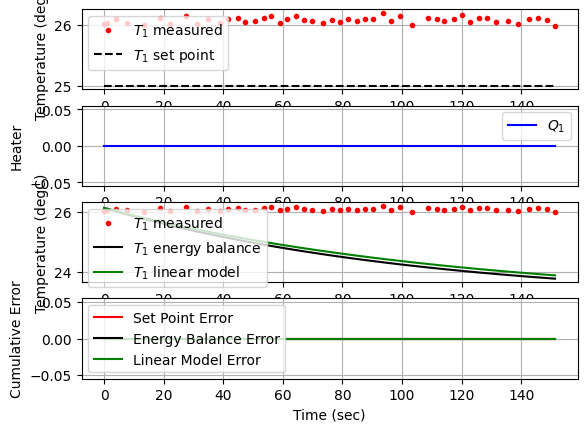

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
 156.3  25.00  26.00   0.00  -0.20   0.00   0.00


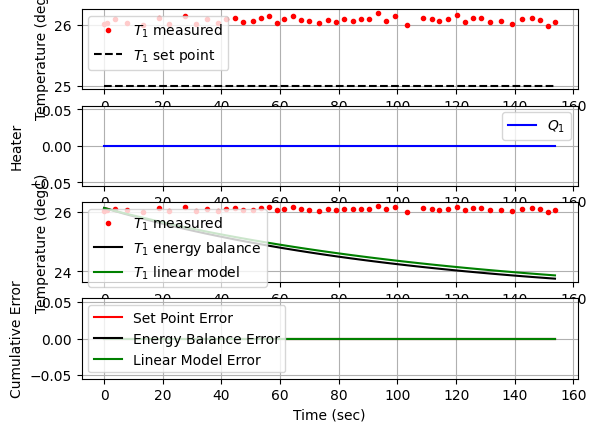

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
 158.8  25.00  25.97   0.00  -0.20   0.00   0.00


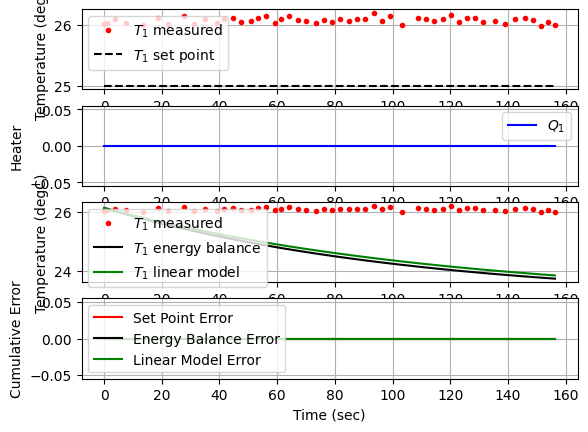

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepShutting down
Arduino disconnected successfully
Arduino disconnected successfully


True

<Figure size 640x480 with 0 Axes>

In [8]:
######################################################
# Do not adjust anything below this point            #
######################################################

# Connect to Arduino
a = itclab.iTCLab()
#a.encode('utf-8').strip()#modification error
# Turn LED on
print('LED On')
a.LED(100)

# Run time in minutes
run_time = 15.0

# Number of cycles
loops = int(60.0*run_time)
tm = np.zeros(loops)

# Temperature
# set point (degC)
Tsp1 = np.ones(loops) * 25.0 
Tsp1[60:] = 45.0
Tsp1[360:] = 30.0
Tsp1[660:] = 35.0
T1 = np.ones(loops) * a.T1 # measured T (degC)
error_sp = np.zeros(loops)

Tsp2 = np.ones(loops) * 23.0 # set point (degC)
T2 = np.ones(loops) * a.T2 # measured T (degC)

# Predictions
Tp = np.ones(loops) * a.T1
error_eb = np.zeros(loops)
Tpl = np.ones(loops) * a.T1
error_fopdt = np.zeros(loops)

# impulse tests (0 - 100%)
Q1 = np.ones(loops) * 0.0
Q2 = np.ones(loops) * 0.0

print('Running Main Loop. Ctrl-C to end.')
print('  Time     SP     PV     Q1   =  P   +  I  +   D')
print(('{:6.1f} {:6.2f} {:6.2f} ' + \
       '{:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
           tm[0],Tsp1[0],T1[0], \
           Q1[0],0.0,0.0,0.0))

# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

# Main Loop
start_time = time.time()
prev_time = start_time
# Integral error
ierr = 0.0
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = a.T1
        T2[i] = a.T2

        # Simulate one time step with Energy Balance
        Tnext = odeint(heat,Tp[i-1]+273.15,[0,dt],args=(Q1[i-1],))
        Tp[i] = Tnext[1]-273.15

        # Simulate one time step with linear FOPDT model
        z = np.exp(-dt/tauP)
        Tpl[i] = (Tpl[i-1]-Tss) * z \
                 + (Q1[max(0,i-int(thetaP)-1)]-Qss)*(1-z)*Kp \
                 + Tss

        # Calculate PID Output (Choose one of them)
        # 1. Manually Choosen
#         [Q1[i],P,ierr,D] = pid(Tsp1[i],T1[i],T1[i-1],ierr,dt)

        # 2. Based on Deep Learning Result
        [Q1[i],P,ierr,D] = pid_dl(Tsp1[i],T1[i],T1[i-1],ierr,dt)

        # Start setpoint error accumulation after 1 minute (60 seconds)
        if i>=60:
            error_eb[i] = error_eb[i-1] + abs(Tp[i]-T1[i])
            error_fopdt[i] = error_fopdt[i-1] + abs(Tpl[i]-T1[i])
            error_sp[i] = error_sp[i-1] + abs(Tsp1[i]-T1[i])

        # Write output (0-100)
        a.Q1(Q1[i])
        a.Q2(0.0)

        # Print line of data
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
              '{:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                  tm[i],Tsp1[i],T1[i], \
                  Q1[i],P,ierr,D))
        
        # Publish data to MQTT Broker
        pub_sp = client.publish('SetPoint', Tsp1[i])
        pub_pv1 = client.publish('Suhu1', T1[i])
        pub_op = client.publish('Nilai_op', Q1[i])

        # Plot
        plt.clf()
        ax=plt.subplot(4,1,1)
        ax.grid()
        plt.plot(tm[0:i],T1[0:i],'r.',label=r'$T_1$ measured')
        plt.plot(tm[0:i],Tsp1[0:i],'k--',label=r'$T_1$ set point')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(4,1,2)
        ax.grid()
        plt.plot(tm[0:i],Q1[0:i],'b-',label=r'$Q_1$')
        plt.ylabel('Heater')
        plt.legend(loc='best')
        ax=plt.subplot(4,1,3)
        ax.grid()
        plt.plot(tm[0:i],T1[0:i],'r.',label=r'$T_1$ measured')
        plt.plot(tm[0:i],Tp[0:i],'k-',label=r'$T_1$ energy balance')
        plt.plot(tm[0:i],Tpl[0:i],'g-',label=r'$T_1$ linear model')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(4,1,4)
        ax.grid()
        plt.plot(tm[0:i],error_sp[0:i],'r-',label='Set Point Error')
        plt.plot(tm[0:i],error_eb[0:i],'k-',label='Energy Balance Error')
        plt.plot(tm[0:i],error_fopdt[0:i],'g-',label='Linear Model Error')
        plt.ylabel('Cumulative Error')
        plt.legend(loc='best')
        plt.xlabel('Time (sec)')
        plt.draw()
        plt.pause(0.05)

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    # Save figure
    plt.savefig('test_PID_dl.png')

# Allow user to end loop with Ctrl-C           
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()
    plt.savefig('test_PID_dl.png')

# Make sure serial connection still closes when there's an error
except:           
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    plt.savefig('test_PID_dl.png')
    raise

a.close()

In [21]:
a.close()

Arduino disconnected successfully


True